In [1]:
from haystack.telemetry import tutorial_running

tutorial_running(27)

In [2]:
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders import PromptBuilder
from haystack import Pipeline


import os
from getpass import getpass
from haystack_integrations.components.generators.amazon_bedrock import AmazonBedrockGenerator


from datasets import load_dataset
from haystack import Document

In [3]:
dataset = load_dataset("bilgeyucel/seven-wonders", split="train")
docs = [Document(content=doc["content"], meta=doc["meta"]) for doc in dataset]

doc_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
doc_embedder.warm_up()

/Users/denys/projects/llm-sandbox/.venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
document_store = InMemoryDocumentStore()

docs_with_embeddings = doc_embedder.run(docs)
document_store.write_documents(docs_with_embeddings["documents"])
retriever = InMemoryEmbeddingRetriever(document_store)

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")

In [6]:
template = """
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

prompt_builder = PromptBuilder(template=template)

In [7]:
generator = AmazonBedrockGenerator(model="anthropic.claude-v2")

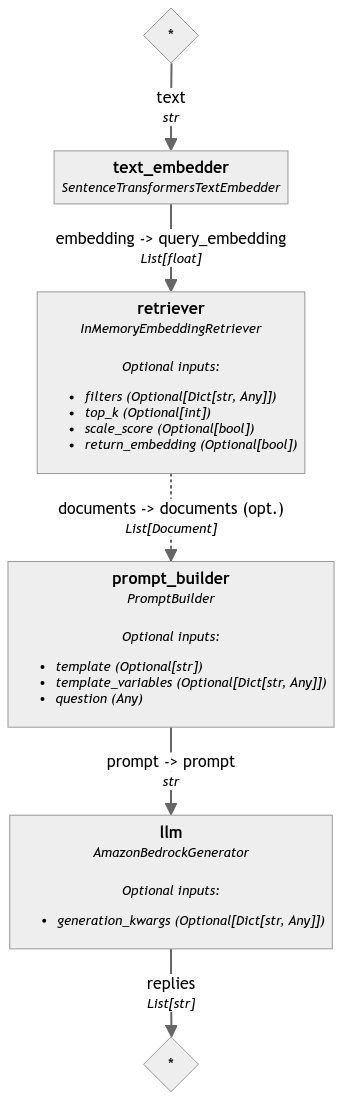

In [8]:
basic_rag_pipeline = Pipeline()
# Add components to your pipeline
basic_rag_pipeline.add_component("text_embedder", text_embedder)
basic_rag_pipeline.add_component("retriever", retriever)
basic_rag_pipeline.add_component("prompt_builder", prompt_builder)
basic_rag_pipeline.add_component("llm", generator)

# Now, connect the components to each other
basic_rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
basic_rag_pipeline.connect("retriever", "prompt_builder.documents")
basic_rag_pipeline.connect("prompt_builder", "llm")

basic_rag_pipeline.show()

In [13]:
question = "What does Rhodes Statue look like?"

response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}},
                                 include_outputs_from={"text_embedder", "retriever", "prompt_builder", "llm"})

print(type(response))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

<class 'dict'>


In [16]:
import json
print(json.dumps(response,default=str))

{"llm": {"replies": ["Unfortunately, there are no definitive descriptions or visual depictions of the full appearance of the Colossus of Rhodes statue. However, based on the information provided, we can make some inferences:\n\n- The statue depicted the Greek sun god Helios. Statues of Helios from ancient Greek art often show him with sun rays radiating from his head and driving a chariot. \n\n- It was made of bronze and likely had a similar material for the face/head. Ancient accounts describe"]}, "text_embedder": {"embedding": [0.0274407546967268, 0.08271685987710953, -0.02266055904328823, 0.030886080116033554, 0.01796674355864525, -0.04623635858297348, 0.01911349594593048, -0.011979078873991966, -0.028749043121933937, -0.006874270271509886, -0.012549925595521927, -0.03317372873425484, -0.034434396773576736, 0.027602916583418846, -0.030476607382297516, -0.018947584554553032, 0.0382225476205349, 0.03223676234483719, -0.020494725555181503, 0.047938134521245956, 0.06141788884997368, -0.